# Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_auc_score as roc, accuracy_score as acc, \
roc_curve, classification_report as cr, confusion_matrix as cm
from sklearn.inspection import permutation_importance


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier

import time

# Get the data

In [2]:
data = pd.read_excel('C://Users//strol//Desktop//tennis.xlsx')

In [3]:
def data_read(data):
    display(data.head())
    display(data.info())
    display(data.describe())
    print('count isnull')
    print(data.isnull().sum())
    print()
    print('count duplicated', sum(data.duplicated()))

In [4]:
data_read(data)

,name,floor,part,player1,player2,rank1,rank2,coef1,coef2,p1win
0,WTA Warsaw Q,clay,0.5,Maleckova J.,Schunk N. M.,216,147,3.25,1.33,1
1,WTA Warsaw Q,clay,0.5,Lee G.,Bednarz Z.,146,10000,1.04,10.50,1
2,WTA Warsaw Q,clay,0.5,Baindl K.,Hatouka Y.,190,225,1.37,3.00,1
3,WTA Warsaw Q,clay,0.5,Hertel A.,Ignatik A.,777,154,6.50,1.10,0
4,WTA Warsaw Q,clay,0.5,Ewald W.,Papamichail D.,10000,180,13.50,1.02,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   name     42 non-null     object 
 1   floor    42 non-null     object 
 2   part     42 non-null     float64
 3   player1  42 non-null     object 
 4   player2  42 non-null     object 
 5   rank1    42 non-null     int64  
 6   rank2    42 non-null     int64  
 7   coef1    42 non-null     float64
 8   coef2    42 non-null     float64
 9   p1win    42 non-null     int64  
dtypes: float64(3), int64(3), object(4)
memory usage: 3.4+ KB


None

,part,rank1,rank2,coef1,coef2,p1win
count,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000
mean,0.333333,405.714286,388.523810,2.542381,3.828333,0.523810
std,0.332061,1526.629881,1521.347754,2.405857,4.821494,0.505487
min,0.062500,1.000000,45.000000,1.010000,1.020000,0.000000
25%,0.062500,105.750000,100.000000,1.330000,1.592500,0.000000
50%,0.125000,132.500000,154.000000,1.720000,2.100000,1.000000
75%,0.500000,190.000000,188.750000,2.327500,3.237500,1.000000
max,1.000000,10000.000000,10000.000000,13.500000,26.000000,1.000000


count isnull
name       0
floor      0
part       0
player1    0
player2    0
rank1      0
rank2      0
coef1      0
coef2      0
p1win      0
dtype: int64

count duplicated 0


Я хочу перенести все меньшие коефициенты в одну сторону, так как прогнозы ориентированы именно на них.

In [5]:
data.loc[data['coef1'] > data['coef2']]

,name,floor,part,player1,player2,rank1,rank2,coef1,coef2,p1win
0,WTA Warsaw Q,clay,0.5000,Maleckova J.,Schunk N. M.,216,147,3.25,1.33,1
3,WTA Warsaw Q,clay,0.5000,Hertel A.,Ignatik A.,777,154,6.50,1.10,0
4,WTA Warsaw Q,clay,0.5000,Ewald W.,Papamichail D.,10000,180,13.50,1.02,0
9,WTA Warsaw Q,clay,1.0000,Lee G.,Ignatik A.,146,154,3.20,1.33,0
10,WTA Warsaw Q,clay,0.5000,Ormaechea P.,Bonaventure Y.,256,149,3.00,1.37,1
13,WTA Warsaw Q,clay,0.5000,Baszak W.,Masarova R.,1009,165,8.80,1.02,0
17,WTA Warsaw,clay,0.0625,Doi M.,Garcia C.,97,45,5.50,1.14,0
20,WTA Warsaw,clay,0.0625,Pigossi L.,Gracheva V.,113,62,2.37,1.57,1
21,WTA Warsaw,clay,0.0625,Maleckova J.,Siniakova K.,216,86,4.50,1.20,0
22,WTA Warsaw,clay,0.0625,Hartono A.,Golubic V.,169,103,2.75,1.44,0


In [6]:
data['p2win'] = 1
data.loc[(data['p1win'] == 1), 'p2win'] = 0

In [7]:
cond = data['coef1'] > data['coef2']

data['player1'], data['player2'] = np.where(cond, (data['player2'],data['player1']),(data['player1'],data['player2']))
data['rank1'], data['rank2'] = np.where(cond, (data['rank2'], data['rank1']), (data['rank1'], data['rank2']))
data['p1win'], data['p2win'] = np.where(cond, (data['p2win'], data['p1win']), (data['p1win'], data['p2win']))
data['coef1'], data['coef2'] = np.where(cond, (data['coef2'], data['coef1']), (data['coef1'], data['coef2']))

In [8]:
data = data.drop(['p2win'], axis=1)

In [9]:
data.loc[data['coef1'] > data['coef2']]

,name,floor,part,player1,player2,rank1,rank2,coef1,coef2,p1win


<b>ТУТ НУЖНЫ ГРАФИКИ!!!!</b>

# EDA

Разделяем колонки на количественные и качественные.

In [10]:
cat_col, quant_col = [], []

for i in data.columns:
    if data[i].dtype == 'float64' or data[i].dtype == 'int64':
        quant_col.append(i)
    else:
        cat_col.append(i)

quant_col.remove('p1win')
print('Колонки с категориальными признаками:')
print(cat_col)
print()
print('Колонки с количественными признаками:')
print(quant_col)

Колонки с категориальными признаками:
['name', 'floor', 'player1', 'player2']

Колонки с количественными признаками:
['part', 'rank1', 'rank2', 'coef1', 'coef2']


In [11]:
dataset = data.copy()
dataset[cat_col].head()

,name,floor,player1,player2
0,WTA Warsaw Q,clay,Schunk N. M.,Maleckova J.
1,WTA Warsaw Q,clay,Lee G.,Bednarz Z.
2,WTA Warsaw Q,clay,Baindl K.,Hatouka Y.
3,WTA Warsaw Q,clay,Ignatik A.,Hertel A.
4,WTA Warsaw Q,clay,Papamichail D.,Ewald W.


Закодируем наши категориальные признаки.

In [12]:
encoder = OrdinalEncoder()

dataset.loc[:, cat_col] = encoder.fit_transform(dataset.loc[:, cat_col]).astype('int64')

In [13]:
print('Распределение классов в датасете:')
display(dataset['p1win'].value_counts(normalize=True))

Распределение классов в датасете:


1    0.595238
0    0.404762
Name: p1win, dtype: float64

Это показывает что 1-й игрок выигрывает немного чаще чем 2-й.

In [14]:
x_dat = dataset.drop('p1win', axis=1)
y_dat = dataset['p1win']

In [15]:
x_train, x_test, y_train, y_test = tts(x_dat, y_dat, random_state=0,
                                      stratify=y_dat)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(31, 9) (11, 9) (31,) (11,)


Масштабируем признаки.

In [16]:
scaler = StandardScaler()

x_train.loc[:, quant_col] = scaler.fit_transform(x_train.loc[:, quant_col])
x_test.loc[:, quant_col] = scaler.fit_transform(x_test.loc[:, quant_col])

In [17]:
print('Распределение классов в тренировочной выборке:')
display(y_train.value_counts(normalize=True))
print('Распределение классов в тестовой выборке:')
display(y_test.value_counts(normalize=True))

Распределение классов в тренировочной выборке:


1    0.580645
0    0.419355
Name: p1win, dtype: float64

Распределение классов в тестовой выборке:


1    0.636364
0    0.363636
Name: p1win, dtype: float64

# Models

In [18]:
models = []

In [19]:
def predict(model, features, target, model_name):
    start_time = time.time()
    pred = model.predict(features)
    print('Время предсказания', time.time() - start_time)
    roc_auc = roc(target, model.predict_proba(features)[:, 1])
    accur = acc(target, pred)
    print('ROC_AUC =', roc_auc)
    print(cr(target, pred))
    models.append((model_name, roc_auc, accur))

In [20]:
start_time = time.time()

logreg = LogisticRegression(solver="liblinear", random_state=0).fit(x_train, y_train)
logreg_name = 'LogisticRegression'

print('Время обучения ', time.time() - start_time)

predict(logreg, x_test, y_test, logreg_name)

Время обучения  0.00498652458190918
Время предсказания 0.0019943714141845703
ROC_AUC = 0.6428571428571428
              precision    recall  f1-score   support

           0       0.50      0.25      0.33         4
           1       0.67      0.86      0.75         7

    accuracy                           0.64        11
   macro avg       0.58      0.55      0.54        11
weighted avg       0.61      0.64      0.60        11



Feature: 0, Score: -0.22652
Feature: 1, Score: 0.00000
Feature: 2, Score: 0.01094
Feature: 3, Score: 0.00622
Feature: 4, Score: -0.00603
Feature: 5, Score: -0.22758
Feature: 6, Score: 0.49274
Feature: 7, Score: -1.13764
Feature: 8, Score: -0.59176


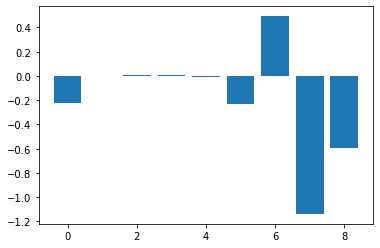

In [21]:
logreg_importance = logreg.coef_[0]
for i,v in enumerate(logreg_importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
plt.bar([x for x in range(len(logreg_importance))], logreg_importance)
plt.show()

In [22]:
rfc = RandomForestClassifier

param_rfc = { 'n_estimators': range (10, 101, 10),
              'max_depth': [5, 7, 9],
              'max_features': [3, 5, 7],
              'min_samples_split': [2, 4, 6],
              'min_samples_leaf': [2, 4, 6] 
            }


grid_rfc = GridSearchCV(rfc(random_state=0), param_rfc, cv=3, scoring='roc_auc', n_jobs = -1)
rfc_name = 'RandomForestClassifier'

start_time = time.time()
grid_rfc.fit(x_train, y_train)
print('Время обучения ', time.time() - start_time)

print(grid_rfc.best_params_)

predict(grid_rfc.best_estimator_, x_test, y_test, rfc_name)

Время обучения  81.05960512161255
{'max_depth': 5, 'max_features': 7, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 10}
Время предсказания 0.015618085861206055
ROC_AUC = 0.5357142857142857
              precision    recall  f1-score   support

           0       0.33      0.25      0.29         4
           1       0.62      0.71      0.67         7

    accuracy                           0.55        11
   macro avg       0.48      0.48      0.48        11
weighted avg       0.52      0.55      0.53        11



In [23]:
rfc_features = pd.DataFrame(data = {'feature': x_train.columns, '%': grid_rfc.best_estimator_.feature_importances_})
rfc_features.sort_values('%', ascending=False).reset_index(drop=True)

,feature,%
0,coef1,0.409694
1,player2,0.180774
2,rank2,0.170211
3,coef2,0.107086
4,player1,0.102932
5,rank1,0.029303
6,name,0.000000
7,floor,0.000000
8,part,0.000000


In [24]:
knc = KNeighborsClassifier

param_knc = { 'n_neighbors': range (1, 20, 1)
            }

grid_knc = GridSearchCV(knc(n_jobs=-1), param_knc, cv=3, scoring='roc_auc', n_jobs=-1)
knc_name = 'KNeighborsClassifier'

start_time = time.time()
grid_knc.fit(x_train, y_train)
print('Время обучения ', time.time() - start_time)

print(grid_knc.best_params_)

predict(grid_knc.best_estimator_, x_test, y_test, knc_name)

Время обучения  0.3171508312225342
{'n_neighbors': 14}
Время предсказания 0.008975744247436523
ROC_AUC = 0.5535714285714286
              precision    recall  f1-score   support

           0       0.50      0.50      0.50         4
           1       0.71      0.71      0.71         7

    accuracy                           0.64        11
   macro avg       0.61      0.61      0.61        11
weighted avg       0.64      0.64      0.64        11



In [25]:
x_train_v, x_valid, y_train_v, y_valid = tts(x_train, y_train, test_size=0.25, random_state=0, stratify=y_train)

In [26]:
cbc = CatBoostClassifier(
    iterations = 2000,
    learning_rate = 0.02,
    depth = 3,
    loss_function='CrossEntropy',
    eval_metric = 'AUC',
    cat_features = cat_col, 
    random_state=0)

start_time = time.time()

cbc.fit(x_train_v, y_train_v, 
    use_best_model=True, 
    eval_set=(x_valid, y_valid),
    logging_level = 'Verbose',
    cat_features=cat_col)

print('Время обучения ', time.time() - start_time)

0:	test: 0.7333333	best: 0.7333333 (0)	total: 161ms	remaining: 5m 20s
1:	test: 0.6666667	best: 0.7333333 (0)	total: 166ms	remaining: 2m 45s
2:	test: 0.6666667	best: 0.7333333 (0)	total: 171ms	remaining: 1m 54s
3:	test: 0.6666667	best: 0.7333333 (0)	total: 177ms	remaining: 1m 28s
4:	test: 0.6666667	best: 0.7333333 (0)	total: 179ms	remaining: 1m 11s
5:	test: 0.6666667	best: 0.7333333 (0)	total: 184ms	remaining: 1m 1s
6:	test: 0.6666667	best: 0.7333333 (0)	total: 190ms	remaining: 54.1s
7:	test: 0.6666667	best: 0.7333333 (0)	total: 194ms	remaining: 48.3s
8:	test: 0.6666667	best: 0.7333333 (0)	total: 199ms	remaining: 44.1s
9:	test: 0.6666667	best: 0.7333333 (0)	total: 203ms	remaining: 40.4s
10:	test: 0.6666667	best: 0.7333333 (0)	total: 208ms	remaining: 37.7s
11:	test: 0.6666667	best: 0.7333333 (0)	total: 214ms	remaining: 35.4s
12:	test: 0.6666667	best: 0.7333333 (0)	total: 219ms	remaining: 33.5s
13:	test: 0.6666667	best: 0.7333333 (0)	total: 225ms	remaining: 31.9s
14:	test: 0.8666667	best:

148:	test: 0.8000000	best: 0.9333333 (18)	total: 902ms	remaining: 11.2s
149:	test: 0.8000000	best: 0.9333333 (18)	total: 908ms	remaining: 11.2s
150:	test: 0.8000000	best: 0.9333333 (18)	total: 914ms	remaining: 11.2s
151:	test: 0.8000000	best: 0.9333333 (18)	total: 920ms	remaining: 11.2s
152:	test: 0.8000000	best: 0.9333333 (18)	total: 923ms	remaining: 11.1s
153:	test: 0.8000000	best: 0.9333333 (18)	total: 929ms	remaining: 11.1s
154:	test: 0.8000000	best: 0.9333333 (18)	total: 934ms	remaining: 11.1s
155:	test: 0.8000000	best: 0.9333333 (18)	total: 939ms	remaining: 11.1s
156:	test: 0.8000000	best: 0.9333333 (18)	total: 945ms	remaining: 11.1s
157:	test: 0.8000000	best: 0.9333333 (18)	total: 952ms	remaining: 11.1s
158:	test: 0.8000000	best: 0.9333333 (18)	total: 957ms	remaining: 11.1s
159:	test: 0.8000000	best: 0.9333333 (18)	total: 962ms	remaining: 11.1s
160:	test: 0.8000000	best: 0.9333333 (18)	total: 967ms	remaining: 11s
161:	test: 0.8000000	best: 0.9333333 (18)	total: 972ms	remaining: 

294:	test: 0.6666667	best: 0.9333333 (18)	total: 1.67s	remaining: 9.66s
295:	test: 0.6666667	best: 0.9333333 (18)	total: 1.68s	remaining: 9.65s
296:	test: 0.6666667	best: 0.9333333 (18)	total: 1.68s	remaining: 9.65s
297:	test: 0.6666667	best: 0.9333333 (18)	total: 1.69s	remaining: 9.64s
298:	test: 0.6666667	best: 0.9333333 (18)	total: 1.69s	remaining: 9.63s
299:	test: 0.6666667	best: 0.9333333 (18)	total: 1.7s	remaining: 9.62s
300:	test: 0.6666667	best: 0.9333333 (18)	total: 1.7s	remaining: 9.61s
301:	test: 0.6666667	best: 0.9333333 (18)	total: 1.71s	remaining: 9.61s
302:	test: 0.6666667	best: 0.9333333 (18)	total: 1.71s	remaining: 9.6s
303:	test: 0.6666667	best: 0.9333333 (18)	total: 1.72s	remaining: 9.59s
304:	test: 0.6666667	best: 0.9333333 (18)	total: 1.72s	remaining: 9.58s
305:	test: 0.6666667	best: 0.9333333 (18)	total: 1.73s	remaining: 9.57s
306:	test: 0.6666667	best: 0.9333333 (18)	total: 1.73s	remaining: 9.56s
307:	test: 0.6666667	best: 0.9333333 (18)	total: 1.74s	remaining: 9

437:	test: 0.6666667	best: 0.9333333 (18)	total: 2.41s	remaining: 8.6s
438:	test: 0.6666667	best: 0.9333333 (18)	total: 2.42s	remaining: 8.6s
439:	test: 0.6666667	best: 0.9333333 (18)	total: 2.42s	remaining: 8.59s
440:	test: 0.6666667	best: 0.9333333 (18)	total: 2.43s	remaining: 8.59s
441:	test: 0.6666667	best: 0.9333333 (18)	total: 2.44s	remaining: 8.58s
442:	test: 0.6666667	best: 0.9333333 (18)	total: 2.44s	remaining: 8.57s
443:	test: 0.6666667	best: 0.9333333 (18)	total: 2.44s	remaining: 8.57s
444:	test: 0.6666667	best: 0.9333333 (18)	total: 2.45s	remaining: 8.56s
445:	test: 0.6666667	best: 0.9333333 (18)	total: 2.46s	remaining: 8.56s
446:	test: 0.6666667	best: 0.9333333 (18)	total: 2.46s	remaining: 8.55s
447:	test: 0.6666667	best: 0.9333333 (18)	total: 2.46s	remaining: 8.54s
448:	test: 0.6666667	best: 0.9333333 (18)	total: 2.47s	remaining: 8.53s
449:	test: 0.6666667	best: 0.9333333 (18)	total: 2.48s	remaining: 8.53s
450:	test: 0.6666667	best: 0.9333333 (18)	total: 2.48s	remaining: 

585:	test: 0.6666667	best: 0.9333333 (18)	total: 3.18s	remaining: 7.68s
586:	test: 0.6666667	best: 0.9333333 (18)	total: 3.19s	remaining: 7.67s
587:	test: 0.6666667	best: 0.9333333 (18)	total: 3.19s	remaining: 7.67s
588:	test: 0.6666667	best: 0.9333333 (18)	total: 3.2s	remaining: 7.67s
589:	test: 0.6666667	best: 0.9333333 (18)	total: 3.21s	remaining: 7.66s
590:	test: 0.6666667	best: 0.9333333 (18)	total: 3.21s	remaining: 7.65s
591:	test: 0.6666667	best: 0.9333333 (18)	total: 3.21s	remaining: 7.65s
592:	test: 0.6666667	best: 0.9333333 (18)	total: 3.22s	remaining: 7.64s
593:	test: 0.6666667	best: 0.9333333 (18)	total: 3.23s	remaining: 7.64s
594:	test: 0.6666667	best: 0.9333333 (18)	total: 3.23s	remaining: 7.63s
595:	test: 0.6666667	best: 0.9333333 (18)	total: 3.24s	remaining: 7.62s
596:	test: 0.6666667	best: 0.9333333 (18)	total: 3.24s	remaining: 7.62s
597:	test: 0.6666667	best: 0.9333333 (18)	total: 3.25s	remaining: 7.61s
598:	test: 0.6666667	best: 0.9333333 (18)	total: 3.25s	remaining:

731:	test: 0.6666667	best: 0.9333333 (18)	total: 3.94s	remaining: 6.83s
732:	test: 0.6666667	best: 0.9333333 (18)	total: 3.95s	remaining: 6.82s
733:	test: 0.6666667	best: 0.9333333 (18)	total: 3.95s	remaining: 6.82s
734:	test: 0.6666667	best: 0.9333333 (18)	total: 3.96s	remaining: 6.81s
735:	test: 0.6666667	best: 0.9333333 (18)	total: 3.96s	remaining: 6.81s
736:	test: 0.6666667	best: 0.9333333 (18)	total: 3.97s	remaining: 6.8s
737:	test: 0.6666667	best: 0.9333333 (18)	total: 3.97s	remaining: 6.79s
738:	test: 0.6666667	best: 0.9333333 (18)	total: 3.98s	remaining: 6.79s
739:	test: 0.6666667	best: 0.9333333 (18)	total: 3.98s	remaining: 6.78s
740:	test: 0.6666667	best: 0.9333333 (18)	total: 3.99s	remaining: 6.78s
741:	test: 0.6666667	best: 0.9333333 (18)	total: 3.99s	remaining: 6.77s
742:	test: 0.6666667	best: 0.9333333 (18)	total: 4s	remaining: 6.77s
743:	test: 0.6666667	best: 0.9333333 (18)	total: 4s	remaining: 6.76s
744:	test: 0.6666667	best: 0.9333333 (18)	total: 4.01s	remaining: 6.75s

877:	test: 0.6666667	best: 0.9333333 (18)	total: 4.7s	remaining: 6s
878:	test: 0.6666667	best: 0.9333333 (18)	total: 4.7s	remaining: 6s
879:	test: 0.6666667	best: 0.9333333 (18)	total: 4.71s	remaining: 5.99s
880:	test: 0.6666667	best: 0.9333333 (18)	total: 4.71s	remaining: 5.99s
881:	test: 0.6666667	best: 0.9333333 (18)	total: 4.72s	remaining: 5.98s
882:	test: 0.6666667	best: 0.9333333 (18)	total: 4.72s	remaining: 5.97s
883:	test: 0.6666667	best: 0.9333333 (18)	total: 4.73s	remaining: 5.97s
884:	test: 0.6666667	best: 0.9333333 (18)	total: 4.73s	remaining: 5.96s
885:	test: 0.6666667	best: 0.9333333 (18)	total: 4.74s	remaining: 5.96s
886:	test: 0.6666667	best: 0.9333333 (18)	total: 4.74s	remaining: 5.95s
887:	test: 0.6666667	best: 0.9333333 (18)	total: 4.75s	remaining: 5.95s
888:	test: 0.6666667	best: 0.9333333 (18)	total: 4.75s	remaining: 5.94s
889:	test: 0.6666667	best: 0.9333333 (18)	total: 4.76s	remaining: 5.94s
890:	test: 0.6666667	best: 0.9333333 (18)	total: 4.76s	remaining: 5.93s


1017:	test: 0.6666667	best: 0.9333333 (18)	total: 5.45s	remaining: 5.26s
1018:	test: 0.6666667	best: 0.9333333 (18)	total: 5.46s	remaining: 5.25s
1019:	test: 0.6666667	best: 0.9333333 (18)	total: 5.46s	remaining: 5.25s
1020:	test: 0.6666667	best: 0.9333333 (18)	total: 5.47s	remaining: 5.24s
1021:	test: 0.6666667	best: 0.9333333 (18)	total: 5.47s	remaining: 5.24s
1022:	test: 0.6666667	best: 0.9333333 (18)	total: 5.48s	remaining: 5.23s
1023:	test: 0.6666667	best: 0.9333333 (18)	total: 5.48s	remaining: 5.22s
1024:	test: 0.6666667	best: 0.9333333 (18)	total: 5.49s	remaining: 5.22s
1025:	test: 0.6666667	best: 0.9333333 (18)	total: 5.49s	remaining: 5.21s
1026:	test: 0.6666667	best: 0.9333333 (18)	total: 5.5s	remaining: 5.21s
1027:	test: 0.6666667	best: 0.9333333 (18)	total: 5.5s	remaining: 5.2s
1028:	test: 0.6666667	best: 0.9333333 (18)	total: 5.51s	remaining: 5.2s
1029:	test: 0.6666667	best: 0.9333333 (18)	total: 5.51s	remaining: 5.19s
1030:	test: 0.6666667	best: 0.9333333 (18)	total: 5.52s

1130:	test: 0.6666667	best: 0.9333333 (18)	total: 6.03s	remaining: 4.63s
1131:	test: 0.6666667	best: 0.9333333 (18)	total: 6.04s	remaining: 4.63s
1132:	test: 0.6666667	best: 0.9333333 (18)	total: 6.04s	remaining: 4.63s
1133:	test: 0.6666667	best: 0.9333333 (18)	total: 6.05s	remaining: 4.62s
1134:	test: 0.6666667	best: 0.9333333 (18)	total: 6.05s	remaining: 4.62s
1135:	test: 0.6666667	best: 0.9333333 (18)	total: 6.06s	remaining: 4.61s
1136:	test: 0.6666667	best: 0.9333333 (18)	total: 6.07s	remaining: 4.6s
1137:	test: 0.6666667	best: 0.9333333 (18)	total: 6.07s	remaining: 4.6s
1138:	test: 0.6666667	best: 0.9333333 (18)	total: 6.08s	remaining: 4.59s
1139:	test: 0.6666667	best: 0.9333333 (18)	total: 6.08s	remaining: 4.59s
1140:	test: 0.6666667	best: 0.9333333 (18)	total: 6.09s	remaining: 4.58s
1141:	test: 0.6666667	best: 0.9333333 (18)	total: 6.09s	remaining: 4.58s
1142:	test: 0.6666667	best: 0.9333333 (18)	total: 6.1s	remaining: 4.57s
1143:	test: 0.6666667	best: 0.9333333 (18)	total: 6.1s

1278:	test: 0.6666667	best: 0.9333333 (18)	total: 6.8s	remaining: 3.83s
1279:	test: 0.6666667	best: 0.9333333 (18)	total: 6.81s	remaining: 3.83s
1280:	test: 0.6666667	best: 0.9333333 (18)	total: 6.82s	remaining: 3.83s
1281:	test: 0.6666667	best: 0.9333333 (18)	total: 6.82s	remaining: 3.82s
1282:	test: 0.6666667	best: 0.9333333 (18)	total: 6.83s	remaining: 3.81s
1283:	test: 0.6666667	best: 0.9333333 (18)	total: 6.83s	remaining: 3.81s
1284:	test: 0.6666667	best: 0.9333333 (18)	total: 6.84s	remaining: 3.8s
1285:	test: 0.6666667	best: 0.9333333 (18)	total: 6.84s	remaining: 3.8s
1286:	test: 0.6666667	best: 0.9333333 (18)	total: 6.85s	remaining: 3.79s
1287:	test: 0.6666667	best: 0.9333333 (18)	total: 6.85s	remaining: 3.79s
1288:	test: 0.6666667	best: 0.9333333 (18)	total: 6.86s	remaining: 3.78s
1289:	test: 0.6666667	best: 0.9333333 (18)	total: 6.86s	remaining: 3.78s
1290:	test: 0.6666667	best: 0.9333333 (18)	total: 6.87s	remaining: 3.77s
1291:	test: 0.6666667	best: 0.9333333 (18)	total: 6.87

1423:	test: 0.6666667	best: 0.9333333 (18)	total: 7.56s	remaining: 3.06s
1424:	test: 0.6666667	best: 0.9333333 (18)	total: 7.56s	remaining: 3.05s
1425:	test: 0.6666667	best: 0.9333333 (18)	total: 7.57s	remaining: 3.05s
1426:	test: 0.6666667	best: 0.9333333 (18)	total: 7.57s	remaining: 3.04s
1427:	test: 0.6666667	best: 0.9333333 (18)	total: 7.58s	remaining: 3.04s
1428:	test: 0.6666667	best: 0.9333333 (18)	total: 7.58s	remaining: 3.03s
1429:	test: 0.6666667	best: 0.9333333 (18)	total: 7.59s	remaining: 3.02s
1430:	test: 0.6666667	best: 0.9333333 (18)	total: 7.59s	remaining: 3.02s
1431:	test: 0.6666667	best: 0.9333333 (18)	total: 7.6s	remaining: 3.01s
1432:	test: 0.6666667	best: 0.9333333 (18)	total: 7.6s	remaining: 3.01s
1433:	test: 0.6666667	best: 0.9333333 (18)	total: 7.61s	remaining: 3s
1434:	test: 0.6666667	best: 0.9333333 (18)	total: 7.61s	remaining: 3s
1435:	test: 0.6666667	best: 0.9333333 (18)	total: 7.62s	remaining: 2.99s
1436:	test: 0.6666667	best: 0.9333333 (18)	total: 7.63s	rem

1570:	test: 0.6666667	best: 0.9333333 (18)	total: 8.32s	remaining: 2.27s
1571:	test: 0.6666667	best: 0.9333333 (18)	total: 8.32s	remaining: 2.27s
1572:	test: 0.6666667	best: 0.9333333 (18)	total: 8.33s	remaining: 2.26s
1573:	test: 0.6666667	best: 0.9333333 (18)	total: 8.34s	remaining: 2.26s
1574:	test: 0.6666667	best: 0.9333333 (18)	total: 8.34s	remaining: 2.25s
1575:	test: 0.6666667	best: 0.9333333 (18)	total: 8.35s	remaining: 2.25s
1576:	test: 0.6666667	best: 0.9333333 (18)	total: 8.35s	remaining: 2.24s
1577:	test: 0.6666667	best: 0.9333333 (18)	total: 8.36s	remaining: 2.23s
1578:	test: 0.6666667	best: 0.9333333 (18)	total: 8.36s	remaining: 2.23s
1579:	test: 0.6666667	best: 0.9333333 (18)	total: 8.37s	remaining: 2.22s
1580:	test: 0.6666667	best: 0.9333333 (18)	total: 8.37s	remaining: 2.22s
1581:	test: 0.6666667	best: 0.9333333 (18)	total: 8.38s	remaining: 2.21s
1582:	test: 0.6666667	best: 0.9333333 (18)	total: 8.38s	remaining: 2.21s
1583:	test: 0.6666667	best: 0.9333333 (18)	total: 8

1719:	test: 0.6666667	best: 0.9333333 (18)	total: 9.09s	remaining: 1.48s
1720:	test: 0.6666667	best: 0.9333333 (18)	total: 9.09s	remaining: 1.47s
1721:	test: 0.6666667	best: 0.9333333 (18)	total: 9.1s	remaining: 1.47s
1722:	test: 0.6666667	best: 0.9333333 (18)	total: 9.11s	remaining: 1.46s
1723:	test: 0.6666667	best: 0.9333333 (18)	total: 9.11s	remaining: 1.46s
1724:	test: 0.6666667	best: 0.9333333 (18)	total: 9.12s	remaining: 1.45s
1725:	test: 0.6666667	best: 0.9333333 (18)	total: 9.12s	remaining: 1.45s
1726:	test: 0.6666667	best: 0.9333333 (18)	total: 9.13s	remaining: 1.44s
1727:	test: 0.6666667	best: 0.9333333 (18)	total: 9.13s	remaining: 1.44s
1728:	test: 0.6666667	best: 0.9333333 (18)	total: 9.14s	remaining: 1.43s
1729:	test: 0.6666667	best: 0.9333333 (18)	total: 9.14s	remaining: 1.43s
1730:	test: 0.6666667	best: 0.9333333 (18)	total: 9.15s	remaining: 1.42s
1731:	test: 0.6666667	best: 0.9333333 (18)	total: 9.15s	remaining: 1.42s
1732:	test: 0.6666667	best: 0.9333333 (18)	total: 9.

1865:	test: 0.6666667	best: 0.9333333 (18)	total: 9.85s	remaining: 707ms
1866:	test: 0.6666667	best: 0.9333333 (18)	total: 9.85s	remaining: 702ms
1867:	test: 0.6666667	best: 0.9333333 (18)	total: 9.86s	remaining: 697ms
1868:	test: 0.6666667	best: 0.9333333 (18)	total: 9.86s	remaining: 691ms
1869:	test: 0.6666667	best: 0.9333333 (18)	total: 9.87s	remaining: 686ms
1870:	test: 0.6666667	best: 0.9333333 (18)	total: 9.87s	remaining: 681ms
1871:	test: 0.6666667	best: 0.9333333 (18)	total: 9.88s	remaining: 676ms
1872:	test: 0.6666667	best: 0.9333333 (18)	total: 9.88s	remaining: 670ms
1873:	test: 0.6666667	best: 0.9333333 (18)	total: 9.89s	remaining: 665ms
1874:	test: 0.6666667	best: 0.9333333 (18)	total: 9.89s	remaining: 660ms
1875:	test: 0.6666667	best: 0.9333333 (18)	total: 9.9s	remaining: 654ms
1876:	test: 0.6666667	best: 0.9333333 (18)	total: 9.9s	remaining: 649ms
1877:	test: 0.6666667	best: 0.9333333 (18)	total: 9.91s	remaining: 644ms
1878:	test: 0.6666667	best: 0.9333333 (18)	total: 9.9

In [27]:
start_time = time.time()

cbc.fit(x_train, y_train, 
             cat_features=cat_col,
             logging_level = 'Silent',
            )

print('Время обучения ', time.time() - start_time)

cbc_pred = cbc.predict(x_test)

roc_auc_cbc = roc(y_test, cbc.predict_proba(x_test)[:, 1])
print('roc_auc для модели CatBoost на тестовой выборке: {}'.format(roc_auc_cbc))
acc_cbc = acc(y_test, cbc_pred)
print('accuracy для модели CatBoost на тестовой выборке {}'.format(acc_cbc))

models.append(('CatBoostClassifier', roc_auc_cbc, acc_cbc))

Время обучения  10.187619924545288
roc_auc для модели CatBoost на тестовой выборке: 0.4642857142857143
accuracy для модели CatBoost на тестовой выборке 0.7272727272727273


In [28]:
models = pd.DataFrame(models, columns=['name', 'roc_auc', 'accuracy'])

In [29]:
models

,name,roc_auc,accuracy
0,LogisticRegression,0.642857,0.636364
1,RandomForestClassifier,0.535714,0.545455
2,KNeighborsClassifier,0.553571,0.636364
3,CatBoostClassifier,0.464286,0.727273


<AxesSubplot:>

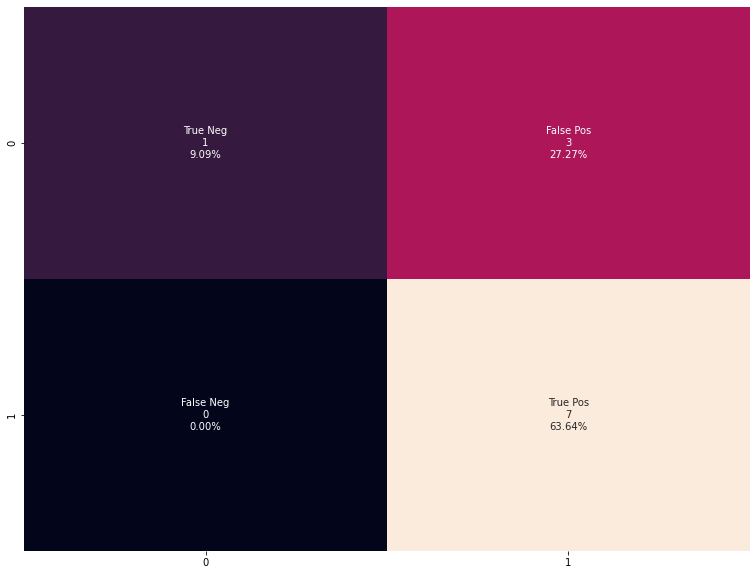

In [30]:
plt.figure(figsize=(13,10))
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cm(y_test, cbc_pred).flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cm(y_test, cbc_pred).flatten()/np.sum(cm(y_test, cbc_pred))]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm(y_test, cbc_pred), annot=labels, fmt='', cbar=False)

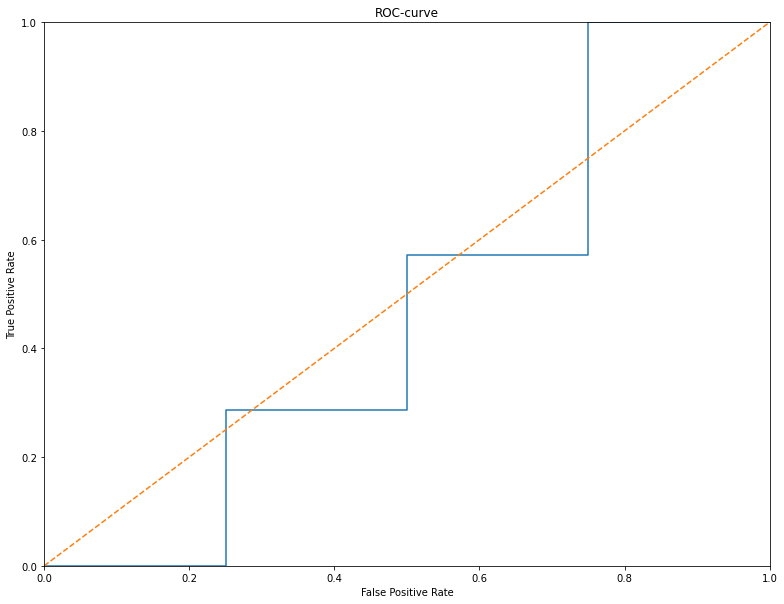

In [31]:
fpr, tpr, thresholds = roc_curve(y_test, cbc.predict_proba(x_test)[:, 1])

plt.figure(figsize=(13,10))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-curve')
plt.show()

In [32]:
cbc_features = pd.DataFrame(data = {'feature': x_test.columns, '%': cbc.feature_importances_})
cbc_features.sort_values('%', ascending=False).reset_index(drop=True)

,feature,%
0,coef1,20.787696
1,coef2,20.397350
2,player2,19.428205
3,rank2,18.957292
4,rank1,13.076280
5,part,4.491241
6,player1,1.546267
7,name,1.315668
8,floor,0.000000


<div style="background: #cceeaa; padding: 5px; border: 1px solid green; border-radius: 5px;">
<font color='green'>
<b>V1</b>
После приведения меньших коефициентов в 1 столбец выросли все метрики.
</font>